<a href="https://colab.research.google.com/github/gakurujnr/First-GOP-Debate-Twitter-Sentiment/blob/master/Python_NLTK_sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

I looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. 
Contributors were asked if the tweet was relevant, which candidate was mentioned, what subject was mentioned, and then what the sentiment was for a given tweet. 

**Sentiment Analysis**: the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.


## Loading Imports Packages

In [29]:
pip install wordcloud

In [30]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
## Loading necessary imports
import numpy as np  ## linear Algebra
import pandas as pd  ## data processing, CSV file I/O (e.g pd.read_csv)

from sklearn.model_selection import train_test_split # function for splitting data to train and test sets
import nltk
from nltk.corpus import stopwords
# nltk.download()

from nltk.classify import SklearnClassifier

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

## Loading Dataset

In [32]:
## Loading Dataset
data = pd.read_csv('Sentiment.csv')

## Keeping only the necessary columns
data = data[['text', 'sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


First, splitting the dataset into a training and a testing set. The test set is the 10% of the original dataset. For this particular analysis I dropped the neutral tweets, as my goal was to only differentiate positive and negative tweets, I remained with the tweets and sentiment.

In [0]:
## Splitting the dataset into train and test set
train, test = train_test_split(data, test_size = 0.1)

## Removing the neutral sentiments
train = train[train.sentiment != "Neutral"]

I then separated the Positive and Negative tweets of training set in order to easily visualize their contained words.
I cleaned the text from hashtags, mentions and links. Now they were ready for a WordCloud visualization which shows only the most emphatic words of the Positive and Negative tweets.

Positive Words


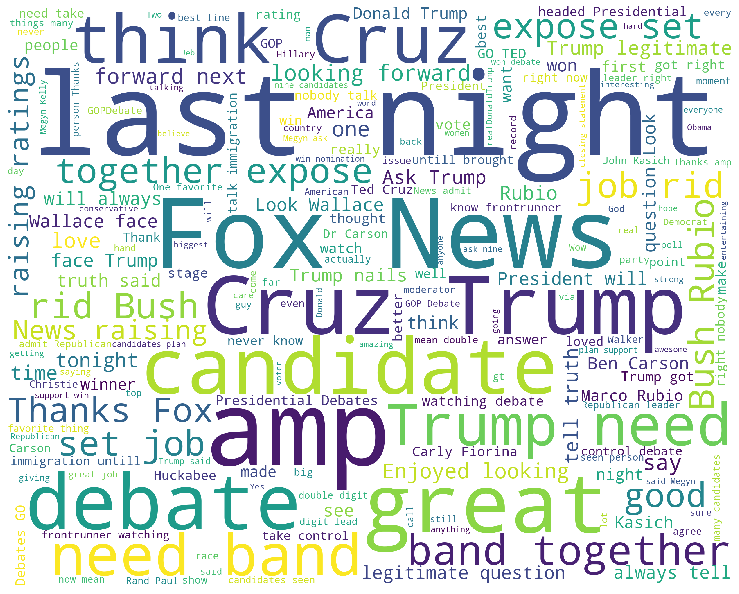

Negative Words


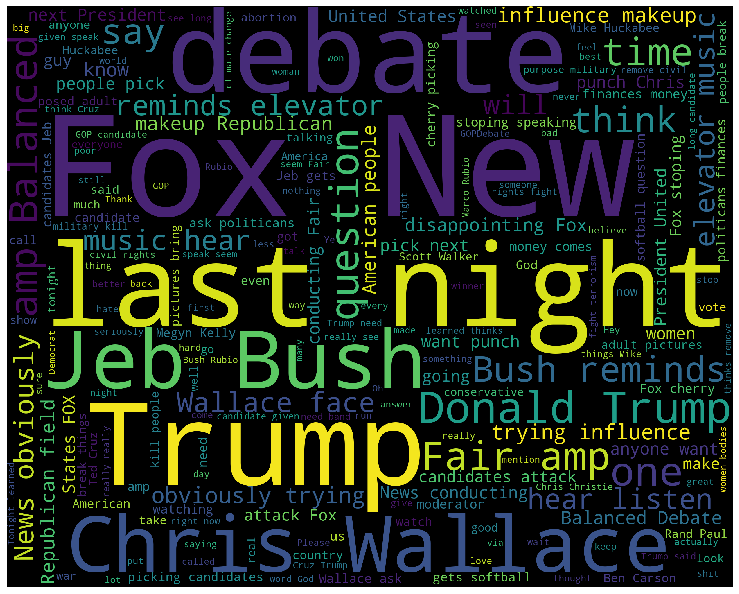

In [34]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
  words = ' '.join(data)
  cleaned_word = " ".join([word for word in words.split()
              if 'http' not in word
                  and not word.startswith('@')
                  and not word.startswith('#')
                  and word != 'RT'])
  wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color = color,
                        width = 2500,
                        height = 2000).generate(cleaned_word)
  plt.figure(1, figsize=(13, 13))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show() 

print("Positive Words")
wordcloud_draw(train_pos,'white')
print("Negative Words")
wordcloud_draw(train_neg)                   

Interesting to notice the following words and expressions in the positive word set: **Truth, STrong, Legitimate, Together, Love, Job**.
In my own intepretation people tend to believe thata their ideal candidate is truthful, legitimate, above good and bad.



In negative tweets contains words like: **Influence, News, Elevator Music, Dissappointing, Softaball, Makeup, Cherry Picking, Trying.**
In my own intepretation people missed the decisively acting and considered the scolded candidates too soft and cherry picking.

After the vizualization, I removed the hashtags, mentions, links and stopwords from the training set.

**Stop Word**: Stop Words are words which do not contain important significance to be used in Search Queries. Usually these words are filtered out from search queries because they return vast amount of unnecessary information. e.g the, for, this e.t.c

In [0]:
##
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
  words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
  words_cleaned = [word for word in words_filtered
      if 'http' not in word
      and not word.startswith('@')
      and not word.startswith('#')
      and word != 'RT']
  words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
  tweets.append((words_without_stopwords, row.sentiment))

  test_pos = test[ test['sentiment'] == 'Positive']
  test_pos = test_pos['text']
  test_neg = test[ test['sentiment'] == 'Negative']
  test_neg = test_neg['text']

As a next step I extracted the features with nltk lib, first by measuring a frequent distribution and by selecting the resulting keys.

In [0]:
## Extracting word features
def get_words_in_tweets(tweets):
  all = []
  for (words, sentiment) in tweets:
    all.extend(words)
    return all

def get_word_features(wordlist):
  wordlist = nltk.FreqDist(wordlist)
  features = wordlist.keys()
  return features

w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
      features['contains(%s)' % word] = (word in document_words)
      return features

I plotted the most frequent distributed words, most words are centred around debate nights.

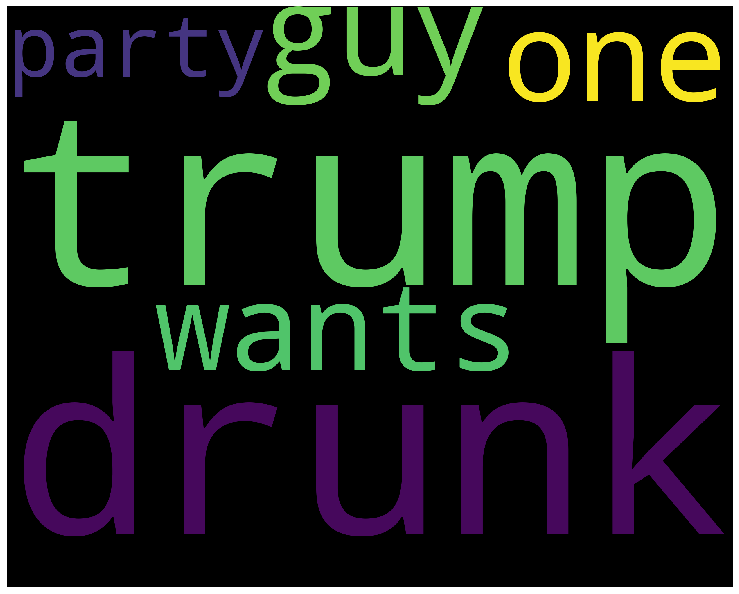

In [37]:
wordcloud_draw(w_features)

Using nltk NaiveBayes Classifier I've classified the extracted tweet word features

In [0]:
# Train the Naive Bayes Classifier
training_set = nltk.classify.apply_features(extract_features, tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

Finally, with not so intelligent metrics, I tried to measure how classifier algorithm scored

In [39]:
neg_cnt = 0
pos_cnt = 0 
for obj in test_neg:
  res = classifier.classify(extract_features(obj.split()))
  if(res == 'Negative'):
    neg_cnt = neg_cnt + 1
for obj in test_pos:
  res = classifier.classify(extract_features(obj.split()))
  if(res == 'Positive'):
    pos_cnt = pos_cnt + 1

print('[Negative]: %s/%s ' % (len(test_neg),neg_cnt))

print('[Positive]: %s/%s ' % (len(test_pos), pos_cnt))

[Negative]: 867/867 
[Positive]: 217/0 


##  Conclusion 

In this project I was curious and exploring how well nltk and the NaiveBayes Machine Learning algorithm performs Sentiment Analysis. It works rather well for negative comments. The problems arise when the tweets are **ironic, sarcastic** has reference or own difficult context.

To improve the evalutation accuracy, we need something to take the context and references into consideration. 

As my next project, I will try to build an LSTM network, and compare its results to this nltk Machine Learning implementation.